# Credit Risk Predictor

This notebook is a solution to the Kaggle Home Credit Group: Credit Default Risk Predictor Challenge. It will explore data, go through feature engineering/selection, and model the data using different ML algotithms.

The datasets used in this notebook belong to the Home Credit Group. Their datasets and Kaggle Challenge info can be found here: https://www.kaggle.com/c/home-credit-default-risk.

The majority of the code in this notebook belongs to me, although it contains some borrowed code from Willkoersen's guided notebooks on this Kaggle problem (found here: https://www.kaggle.com/willkoehrsen/start-here-a-gentle-introduction). 



In [249]:
import pandas as pd
import numpy as np
#matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

#import utilities
import utilities
from utilities import kde_target

from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.impute import SimpleImputer

#supress warnings from pandas
import warnings
warnings.filterwarnings('ignore')

plt.style.use('fivethirtyeight')


In [250]:
#importing the training and testing datasets

app_train = pd.read_csv('Data/application_train.csv')

app_test = pd.read_csv('Data/application_test.csv')

## Building off of past EDA

The two preceding files 'EDA.ipynb' and 'featEng1.ipynb' we walked through Exploratory Data Analysis of the the training and testing set, and the bureau and bureau_balance set - as outlined on Kaggle found here (https://www.kaggle.com/willkoehrsen/start-here-a-gentle-introduction/notebook and https://www.kaggle.com/willkoehrsen/introduction-to-manual-feature-engineering). 

In this notebook, I intend to build off of the findings in these two Kaggle notebooks - by:
- adding better domain knowledge features
- incorporating the remaining datasets

This notebook will focus on exploring and engineering better features, before we begin work on feature selection.

Somethings to note:
- Individuals who **did not** repay their loan are: **TARGET == 1**
- Individuals who **did** repay their loan are: **TARGET == 0**  

The describe() function gives us general statistics of a dataset

The head() function gives us the first few rows of the dataframe (5 rows if no changes made)

### Exploring and Preprocessing Data

We using the EDA.ipynb and featEng1.ipynb (which are copies of the tutorial found here: https://www.kaggle.com/willkoehrsen/start-here-a-gentle-introduction) - we will follow `willkoehrsen`'s steps for exploring and preprocessing our data, before building our own domain knowledge features.

In [251]:
print('Training Data Shape: ', app_train.shape)

app_train.describe()

Training Data Shape:  (307511, 122)


,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.000000,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,307511.000000,307511.000000,...,307511.000000,307511.000000,307511.000000,307511.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000
mean,278180.518577,0.080729,0.417052,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,0.020868,-16036.995067,63815.045904,...,0.008130,0.000595,0.000507,0.000335,0.006402,0.007000,0.034362,0.267395,0.265474,1.899974
std,102790.175348,0.272419,0.722121,2.371231e+05,4.024908e+05,14493.737315,3.694465e+05,0.013831,4363.988632,141275.766519,...,0.089798,0.024387,0.022518,0.018299,0.083849,0.110757,0.204685,0.916002,0.794056,1.869295
min,100002.000000,0.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,0.000290,-25229.000000,-17912.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,189145.500000,0.000000,0.000000,1.125000e+05,2.700000e+05,16524.000000,2.385000e+05,0.010006,-19682.000000,-2760.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,278202.000000,0.000000,0.000000,1.471500e+05,5.135310e+05,24903.000000,4.500000e+05,0.018850,-15750.000000,-1213.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,367142.500000,0.000000,1.000000,2.025000e+05,8.086500e+05,34596.000000,6.795000e+05,0.028663,-12413.000000,-289.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
max,456255.000000,1.000000,19.000000,1.170000e+08,4.050000e+06,258025.500000,4.050000e+06,0.072508,-7489.000000,365243.000000,...,1.000000,1.000000,1.000000,1.000000,4.000000,9.000000,8.000000,27.000000,261.000000,25.000000


In [252]:
app_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [253]:
app_train.shape

(307511, 122)

### Examining Missing Values

The missing_values_table fucntion will be used to examine the number of missing values and their precentages in the columns of the dataframe.

This can be used to determine if there are any features that we can remove, due to a lack of entries.

In [254]:
#function to find missing the total and percentage of missing values in the columns in a dataframe

def missing_values_table(df):
    #Total missing values
    mis_val = df.isnull().sum()

    #precentage missing values
    mis_val_percent = 100 * mis_val / len(df)
    #mis_val_percent = 100 * df.isnull().sum / len(df)
    
    #make table with results
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)

    #rename the columns
    mis_val_table_col_rename = mis_val_table.rename(columns = {0: 'Missing Values', 1: '% of Total Values'})

    #sort table by precentage of missing vals decending
    mis_val_table_col_rename = mis_val_table_col_rename[mis_val_table_col_rename.iloc[:,1]!=0].sort_values('% of Total Values', ascending = False).round(1)

    #print summary info
    print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n" +"There are " + str(mis_val_table_col_rename.shape[0]) + " columns that have missing values.")
        
    # Return the dataframe with missing information
    return mis_val_table_col_rename

For now, let's check the missing values table - and see if there are any columns with missing values that are over 90%.

If so, then we will remove them.

In [255]:
missing_values = missing_values_table(app_train)

missing_values.head()

Your selected dataframe has 122 columns.
There are 67 columns that have missing values.


,Missing Values,% of Total Values
COMMONAREA_MEDI,214865,69.9
COMMONAREA_AVG,214865,69.9
COMMONAREA_MODE,214865,69.9
NONLIVINGAPARTMENTS_MEDI,213514,69.4
NONLIVINGAPARTMENTS_MODE,213514,69.4


There does not seem to be any features with >90% missing values. So for now, I will not remove any from the dataframe.

### Column Types and Unique Features

We will examine the types of values in the columns. In addition, we will explore the number of Unique string values in the columns with `object` datatypes. 

In [256]:
# examining the number of columns of different datatypes
app_train.dtypes.value_counts()

float64    65
int64      41
object     16
dtype: int64

In [257]:
# examining the number of unique strings in each object column
app_train.select_dtypes('object').apply(pd.Series.nunique, axis =0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

### Encoding Categorical Values

Most ML models are unable to handle categorical (string, object) values. Therefore we must encode them to ints for processing. 

Two most common types of encoding are:
- label encoding: assigning each unique categorical label an integer
- one hot encoding: creating new columns, that have 1's where a category exisits and 0's otherwise

Note: Label encoding is fine for cols with two categories (otherwise model might arbitrarily order them). One hot encoding is better for cols with >2 categories.

For label encoding, we use the Scikit-Learn LabelEncoder and for one-hot encoding, the pandas get_dummies(df) function.

In [258]:
#binary label encoding and one hot encoding for training dataset
app_train = utilities.label_encoder(app_train)
app_train = utilities.one_hot_encoder(app_train)

print('\n\n\n############TEST DF###############')
#binary label encoding and one hot encoding for testing dataset
app_test = utilities.label_encoder(app_test)
app_test = utilities.one_hot_encoder(app_test)

SK_ID_CURR
TARGET
NAME_CONTRACT_TYPE
CODE_GENDER
FLAG_OWN_CAR
FLAG_OWN_REALTY
CNT_CHILDREN
AMT_INCOME_TOTAL
AMT_CREDIT
AMT_ANNUITY
AMT_GOODS_PRICE
NAME_TYPE_SUITE
NAME_INCOME_TYPE
NAME_EDUCATION_TYPE
NAME_FAMILY_STATUS
NAME_HOUSING_TYPE
REGION_POPULATION_RELATIVE
DAYS_BIRTH
DAYS_EMPLOYED
DAYS_REGISTRATION
DAYS_ID_PUBLISH
OWN_CAR_AGE
FLAG_MOBIL
FLAG_EMP_PHONE
FLAG_WORK_PHONE
FLAG_CONT_MOBILE
FLAG_PHONE
FLAG_EMAIL
OCCUPATION_TYPE
CNT_FAM_MEMBERS
REGION_RATING_CLIENT
REGION_RATING_CLIENT_W_CITY
WEEKDAY_APPR_PROCESS_START
HOUR_APPR_PROCESS_START
REG_REGION_NOT_LIVE_REGION
REG_REGION_NOT_WORK_REGION
LIVE_REGION_NOT_WORK_REGION
REG_CITY_NOT_LIVE_CITY
REG_CITY_NOT_WORK_CITY
LIVE_CITY_NOT_WORK_CITY
ORGANIZATION_TYPE
EXT_SOURCE_1
EXT_SOURCE_2
EXT_SOURCE_3
APARTMENTS_AVG
BASEMENTAREA_AVG
YEARS_BEGINEXPLUATATION_AVG
YEARS_BUILD_AVG
COMMONAREA_AVG
ELEVATORS_AVG
ENTRANCES_AVG
FLOORSMAX_AVG
FLOORSMIN_AVG
LANDAREA_AVG
LIVINGAPARTMENTS_AVG
LIVINGAREA_AVG
NONLIVINGAPARTMENTS_AVG
NONLIVINGAREA_AVG
APART

In [259]:
app_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes
0,100002,1,0,0,1,0,202500.0,406597.5,24700.5,351000.0,...,0,0,0,0,0,0,1,0,1,0
1,100003,0,0,0,0,0,270000.0,1293502.5,35698.5,1129500.0,...,0,1,0,0,0,0,0,0,1,0
2,100004,0,1,1,1,0,67500.0,135000.0,6750.0,135000.0,...,0,0,0,0,0,0,0,0,0,0
3,100006,0,0,0,1,0,135000.0,312682.5,29686.5,297000.0,...,0,0,0,0,0,0,0,0,0,0
4,100007,0,0,0,1,0,121500.0,513000.0,21865.5,513000.0,...,0,0,0,0,0,0,0,0,0,0


In [260]:
app_train.shape

(307511, 243)

In [261]:
app_test.shape

(48744, 238)

### Result of Encoding

As we can see - after binary label encoding and one hot encoding the the number of features in the app_train dataframe has increased (originally it had 122 columns). The number of features in the app_test dataframe has increased as well.


### Aligining Dataframes

Once training and testing datasets have been encoded. New features will be created in the respective datasets. Aliging the datasets will ensure the same features are present in both training and testing datasets.

In [262]:
# Aligning training and testing datasets

app_train, app_test = utilities.dataframe_alignment(app_train, app_test, 'TARGET')


Training Features Shape:  (307511, 238)
Testing Features Shape:  (48744, 237)


# Creating Domain Knowledge Features

Domain Knowledge features are features that are built out of knowledge of the problem to be solved. Below I have created a number of features using the train|test datasets. 

As this notebook continues on I'll be adding more (and more complex) domain features as more datasets are joined together.

### Binning Age at Time of Loan Disbursement
It may be useful to explore the impact of age on loan repayment. Although the age of the applicant shouldn't necessarily be viewed as a barring factor in the loan process, it could help determine whether the applicant might need increased financial literacy.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002B6662D0430>]],
      dtype=object)

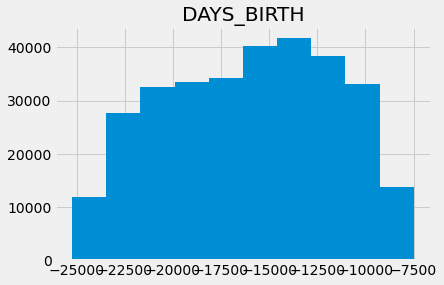

In [263]:
app_train.hist(column='DAYS_BIRTH')

In [264]:
#adding years birth to app_train & app_test
app_train['YEARS_BIRTH'] = abs(app_train['DAYS_BIRTH']/365)

app_test['YEARS_BIRTH'] = abs(app_test['DAYS_BIRTH']/365)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002B61DAC2D00>]],
      dtype=object)

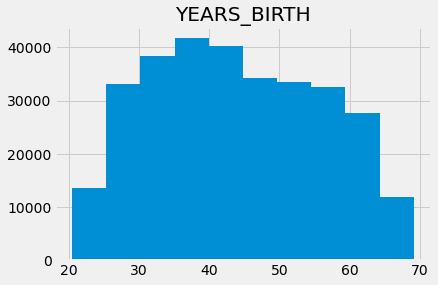

In [265]:
app_train.hist(column='YEARS_BIRTH')

### Creating Age Quintiles

In order to better explore the age of applicants, I have decide to 'bin' into age range quintiles. A feature that considers age in segments may be a more useful determinant of default risk

In [266]:
app_train['YEARS_BIRTH_QUANT5'] = pd.qcut(app_train['YEARS_BIRTH'], q=5)

app_test['YEARS_BIRTH_QUANT5'] = pd.qcut(app_test['YEARS_BIRTH'], q=5)

In [267]:
app_train.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,...,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,TARGET,YEARS_BIRTH,YEARS_BIRTH_QUANT5
0,100002,0,0,1,0,202500.0,406597.5,24700.5,351000.0,0.018801,...,0,0,0,1,0,1,0,1,25.920548,"(20.517, 32.038]"
1,100003,0,0,0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,...,0,0,0,0,0,1,0,0,45.931507,"(39.496, 47.178]"
2,100004,1,1,1,0,67500.0,135000.0,6750.0,135000.0,0.010032,...,0,0,0,0,0,0,0,0,52.180822,"(47.178, 56.093]"
3,100006,0,0,1,0,135000.0,312682.5,29686.5,297000.0,0.008019,...,0,0,0,0,0,0,0,0,52.068493,"(47.178, 56.093]"
4,100007,0,0,1,0,121500.0,513000.0,21865.5,513000.0,0.028663,...,0,0,0,0,0,0,0,0,54.608219,"(47.178, 56.093]"


### Calculating Downpayment

Both the `application_train` and `application_test` datasets contain the features `AMT_CREDIT` and `AMT_GOODS_PRICE`. 

In this context, it appears that the `AMT_CREDIT` column refers to principal of the loan. 

In contrast `AMT_GOODS_PRICE` appears to refer to the the balance of the loan minus downpayment.

Therefore `AMT_CREDIT` - `AMT_GOODS_PRICE`  = `DOWNPAYMENT`

In [268]:
# creating domain knowledge datasets
app_train_domain = app_train.copy()

app_test_domain = app_test.copy()

In [269]:
#calculating downpayment for training dataset
app_train_domain['DOWNPAYMENT'] = app_train_domain['AMT_CREDIT'] - app_train_domain['AMT_GOODS_PRICE']

#calculating downpayment for testing dataset
app_test_domain['DOWNPAYMENT'] = app_test_domain['AMT_CREDIT'] - app_test_domain['AMT_GOODS_PRICE']

### Ratio of Downpayment to Loan

A potentially useful feature to explore is the ratio between the Downpayment made by a client and the Principal of their loan. 

In order to explore this we will use the formula:
`DOWNPAYMENT` / `AMT_CREDIT`

In [270]:
# Calculating ratio of downpayment to loan in training dataset

app_train_domain['RATIO_DOWN_LOAN'] = app_train_domain['DOWNPAYMENT'] / app_train_domain['AMT_CREDIT']

# Calcualting the ratio of downpayment to loan in testing dataset
app_test_domain['RATIO_DOWN_LOAN'] = app_test_domain['DOWNPAYMENT'] / app_test_domain['AMT_CREDIT']

### Ratio of Income to Loan

An ideal ratio to help determine whether an individual will default on their loan is a `debt to assets ratio`. In short, if an individuals debt is larger than their assets - it is a good indicator that lending to them would be risky.

However, it is difficult to determine the true value an individuals assets soley based on the data provided. Due to our lack of information - it is a good idea to subtitute a debt:assets ratio with a `debt to income ratio`.

Our debt:income ratio will use the divide a clients AMT_GOODS_PRICE (or the remaining amount of debt after downpayment) by the client's reported income. 

In [271]:
#calculating debt:income ratio training
app_train_domain['RATIO_DEBT_INCOME'] = app_train_domain['AMT_GOODS_PRICE'] / app_train_domain['AMT_INCOME_TOTAL']

#calculating debt:income ratio testing
app_test_domain['RATIO_DEBT_INCOME'] = app_test_domain['AMT_GOODS_PRICE'] / app_test_domain['AMT_INCOME_TOTAL']


The correlation between RATIO_DEBT_INCOME and the TARGET is -0.0176
Median value for the loan that was not repaid = 2.8571
Median value for loan that was repaid = 2.9423


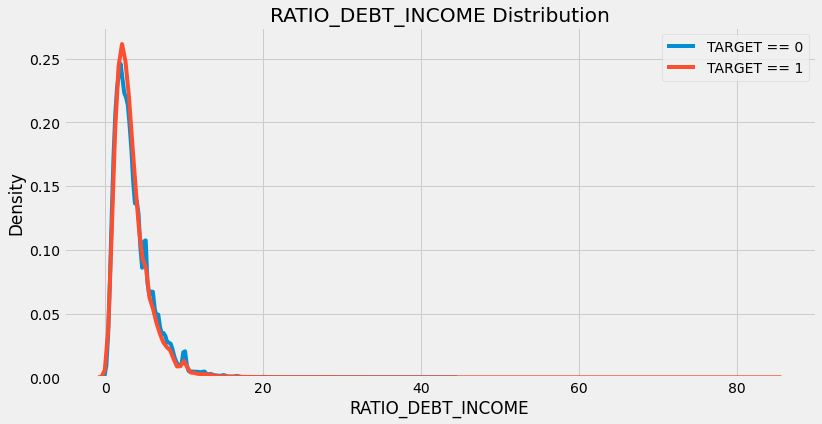

In [245]:
utilities.kde_target('RATIO_DEBT_INCOME', app_train_domain)

### Estimating Assets in Debt to Asset Ratio

Key information that we are missing to correctly make assumptions about this dataset are:
- Country dataset is from
- Currency dataset is in

These can be used to estimate the value of assets such as cars and real estate.

However, based on the information we have (and a little research) it is possible to estimate the origin of the dataset. Using information found in this Kaggle thread from the Home Credit Default Risk competition (https://www.kaggle.com/c/home-credit-default-risk/discussion/62122) we can make the assumption that the dataset is from `Kazakhstan'.

Users in the thread used the following information to assume Kazakhstan as the dataset origin:
- Countries Home Credit Operates in
- Number of Cedit Bureaus
- Retirement Age distribution by Gender
- FONDKAPREMONT_MODE paramenter in app_train

Using the assumptions in this dataset we will make the following assumptions to estimate an individuals assets.
- The Average Sale Price of Real Estate in Almaty: `46000000 KZT` (https://find-price-order.com/apartments-cost-almaty-apartments-rate-kazakhstan)
- The Average Sale Price of a New Corolla Sedan in Almaty: `8118662 KZT` (https://www.numbeo.com/cost-of-living/in/Almaty)

Although it is far less accurate - in order to simplify my feature, I will use the assumption that every individual who owns property in Kazakhstan owns at the average sale price of real estate, and has a Toyota Corolla.


### calculating car value after depreciation


In [246]:
def car_depreciation(df):
    car_values = []

    count = 0
    for row in df['FLAG_OWN_CAR']:
        if row == 0:
            car_values.append(0)
        elif row == 1:
            age = df.iloc[count]['OWN_CAR_AGE']
            age.astype(np.int64)
            
            if np.isnan(age):
                age = 0
           
            car = 8118662
            for yr in range(int(age)):
                if yr == 0:
                    car = car - (car*0.2)
                else:
                    car = car - (car * 0.1)
            car_values.append(car)
        count += 1

    return car_values

In [247]:
app_train_domain['CAR_VALUES'] = car_depreciation(app_train_domain)

app_test_domain['CAR_VALUES'] = car_depreciation(app_test_domain)

# check = car_depreciation(app_test_domain)
# print(check)

In [277]:
app_train_domain.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,...,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,YEARS_BIRTH,YEARS_BIRTH_QUANT5,DOWNPAYMENT,RATIO_DOWN_LOAN,RATIO_DEBT_INCOME,CAR_VALUES
0,100001,0,0,1,0,135000.0,568800.0,20560.5,450000.0,0.018850,...,1,0,1,0,52.715068,"(47.197, 56.06]",118800.0,0.208861,3.333333,0.000000e+00
1,100005,0,0,1,0,99000.0,222768.0,17370.0,180000.0,0.035792,...,0,0,0,0,49.490411,"(47.197, 56.06]",42768.0,0.191984,1.818182,0.000000e+00
2,100013,0,1,1,0,202500.0,663264.0,69777.0,630000.0,0.019101,...,0,0,0,0,54.898630,"(47.197, 56.06]",33264.0,0.050152,3.111111,4.261323e+06
3,100028,0,0,1,2,315000.0,1575000.0,49018.5,1575000.0,0.026392,...,0,0,1,0,38.290411,"(32.288, 39.671]",0.0,0.000000,5.000000,0.000000e+00
4,100038,0,1,0,1,180000.0,625500.0,32067.0,625500.0,0.010032,...,0,0,0,0,35.726027,"(32.288, 39.671]",0.0,0.000000,3.475000,1.337248e+06


In [59]:
## Examining Correlations

The correlation between AMT_CREDIT and the TARGET is -0.0304
Median value for the loan that was not repaid = 497520.0000
Median value for loan that was repaid = 517788.0000


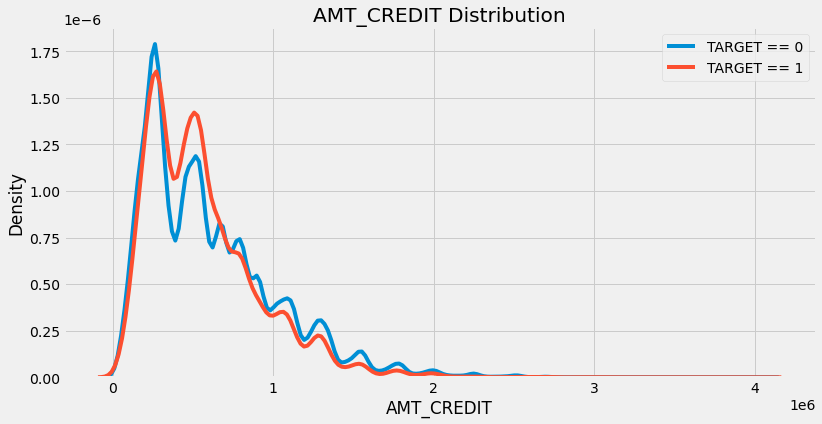

In [60]:
#import utilities
from utilities import kde_target

utilities.kde_target('AMT_CREDIT', app_train)